# HOT Region Interpretation

### The following section rebuilds the classifier to use for interpretation. Interpretation starts at code cell [8].

The following cell defines file names and parameters.

- **kmer_length** denotes the number of basepairs considered when converting sequences to kmers
- **sampling_percentage** denotes the percentage of sequences that will be used to build the model
- **seed** is for reproducing results
- **top_kmers** denotes the number of top kmers to be displayed and considered for GC calculations

In [1]:
input_hot = 'hot_regions_01_all.fa'
input_lot = 'lot_regions_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 100
top_kmers = 6

The following cell includes all imports used in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler, normalize
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

The following cell parses the input Fasta files for HOT and LOT sequences and builds lists of the sequences.

In [3]:
with open(input_hot) as fasta_file:
    hot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        hot_sequences.append(sequence)

with open(input_lot) as fasta_file:
    lot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        lot_sequences.append(sequence)

The following cell creates dataframes for the HOT and LOT sequences with the following labels:
- *1* for HOT sequences (positive class)
- *0* for LOT sequences (negative class)

In [4]:
df_hot = pd.DataFrame(hot_sequences, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences, columns=['sequence'])
df_lot['label'] = 0

The following cell performs downsampling on the majority class using **seed** and aggregates the sequences inside *df_resample*.

In [5]:
if df_hot.shape[0] < df_lot.shape[0]:
    df_minority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_majority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)
else:
    df_majority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_minority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)

df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=seed)
df_resample = pd.concat([df_majority_downsampled, df_minority])

The following cell defines a helper function that returns the extracted kmers from the sequences. Next, it replaces the HOT/LOT sequences by their extracted kmers (list format). Finally it converts each list of kmers into sentences to be fed into CountVectorizer.

In [6]:
def kmers(seq, length):
    return [seq[i:i+length].lower() for i in range(len(seq)-length+1)]

df_resample['kmers'] = df_resample.apply(lambda a: kmers(a['sequence'], kmer_length), axis=1)
df_resample.drop('sequence',axis=1, inplace=True)
df_resample = df_resample.reset_index()
df_resample.drop('index', axis=1, inplace=True)

kmer_sentences = list(df_resample['kmers'])
for x in range(len(kmer_sentences)):
    kmer_sentences[x] = ' '.join(kmer_sentences[x])

labels = df_resample.iloc[:,0].values

The following cell counts kmer occurences in the sentences using CountVectorizer and performs Min-Max normalization on the vectors. 

In [7]:
c = CountVectorizer(ngram_range=(1,1))
x = c.fit_transform(kmer_sentences)

x_normalized = normalize(x, norm='l1')
scaler = MaxAbsScaler()
x_scaled = scaler.fit_transform(x_normalized)
scaled_df_unsorted = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
scaled_df = scaled_df_unsorted.reindex(sorted(scaled_df_unsorted.columns), axis=1)

The following cell builds and tests the Support Vector Classifier on the kmer distribution data, displaying the accuracy below.

In [8]:
clf = SVC(C=1.0, kernel='linear', gamma=0.05)
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, labels, test_size = 0.15, random_state=seed)

clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print('Accuracy using SVM =', round(accuracy_score(Y_test, Y_pred), 4))

Accuracy using SVM = 0.9425


### Interpretation

The following cell visualizes the average kmer distributions (lexicographic order) of HOT Regions. 

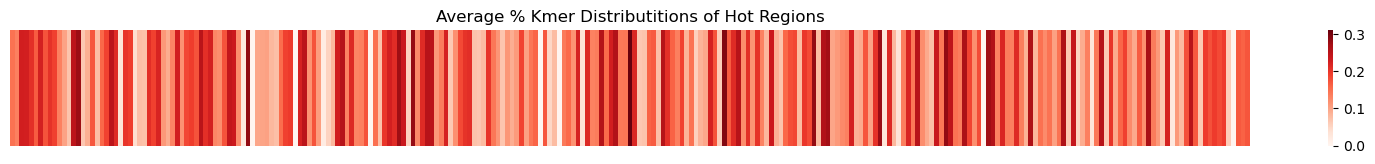

In [9]:
kmer_dist_hot = scaled_df.loc[(scaled_df.shape[0]/2):,:].mean()
a = np.expand_dims(kmer_dist_hot.values, axis=0)
plt.figure(figsize = (20,1.5))
ax = sns.heatmap(a, annot=False, cmap='Reds')
ax.set_yticks([])
ax.set_xticks([])
plt.title('Average % Kmer Distributitions of Hot Regions')
plt.show()

The following cell visualizes the average kmer distributions (lexicographic order) of LOT Regions.

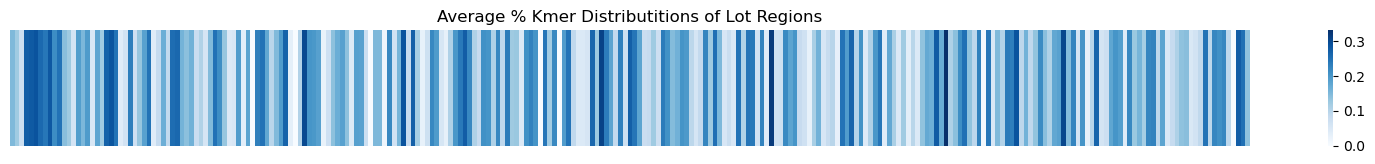

In [10]:
kmer_dist_lot = scaled_df.loc[:(scaled_df.shape[0]/2)-1,:].mean()
a = np.expand_dims(kmer_dist_lot.values, axis=0)
plt.figure(figsize = (20,1.5))
ax = sns.heatmap(a, annot=False, cmap='Blues')
ax.set_yticks([])
ax.set_xticks([])
plt.title('Average % Kmer Distributitions of Lot Regions')
plt.show()

The following cell visualizes the differences between average kmer distributions (lexicographic order) of HOT and LOT Regions.

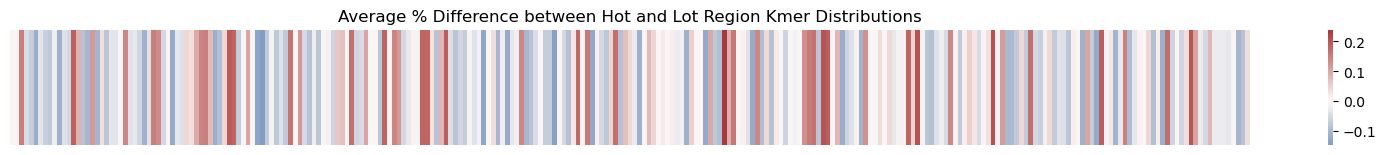

In [11]:
diff_df = kmer_dist_hot - kmer_dist_lot
a = np.expand_dims(diff_df.values, axis=0)
plt.figure(figsize = (20,1.5))
ax = sns.heatmap(a, annot=False, cmap='vlag', center=0.00)
ax.set_yticks([])
ax.set_xticks([])
plt.title('Average % Difference between Hot and Lot Region Kmer Distributions')
plt.show()

The following cell calculates the kmers with the top 5 highest and lowest fitted weights. These kmers sway the classifier decision the most.

In [12]:
weights = pd.DataFrame.sparse.from_spmatrix(clf.coef_, columns=c.vocabulary_)

max_weights = pd.DataFrame(weights.columns.values[np.argsort(-weights.values, axis=1)[:,:top_kmers]])
max_weights_values = weights.loc[:,max_weights.loc[0]]

min_weights = pd.DataFrame(weights.columns.values[np.argsort(weights.values, axis=1)[:,:top_kmers]])
min_weights_values = weights.loc[:,min_weights.loc[0]]

print('Top', str(top_kmers), 'positive weight kmers:')
display(max_weights_values)
print('Top', str(top_kmers), 'negative weight kmers:')
display(min_weights_values)

Top 6 positive weight kmers:


,gtgt,ttat,catg,agcc,cccg,acac
0,1.8682,1.396549,1.396454,1.207435,1.15417,1.085557


Top 6 negative weight kmers:


,caga,tagt,cgac,ttgt,caat,acag
0,-0.951652,-0.946832,-0.921953,-0.836839,-0.824652,-0.824235


The following cell displays the fitted intercept. A negative classification decision (LOT Region) makes sense, as a sequence with no base pairs at all (all counts equal to 0) should probably not be classified as a HOT Region.

In [13]:
clf.intercept_

array([-1.17019724])

The following cell defines a helper function that calculates the GC content of a sequence, which is used to calculate the GC content of the top positive and negative weights. The GC content is then printed.

In [14]:
# Helper function for calculating gc content of a sequence
def gc(s):
    temp = s.lower()
    a = temp.count('a')
    g = temp.count('g')
    c = temp.count('c')
    t = temp.count('t')
    return round((g + c) / (a + g + c + t) * 100,1)

# Printing overall gc content of highest positive and negative weights
hot_kmers = ''.join(list(max_weights_values))
lot_kmers = ''.join(list(min_weights_values))

print('GC content of top', str(top_kmers), 'HOT kmers is: ' + str(gc(hot_kmers))+'%')
print('GC content of top', str(top_kmers), 'LOT kmers is: ' + str(gc(lot_kmers))+'%')

GC content of top 6 HOT kmers is: 54.2%
GC content of top 6 LOT kmers is: 41.7%


The following cell plots the GC Content distributions when considering increasing numbers of top positive and negative weights.

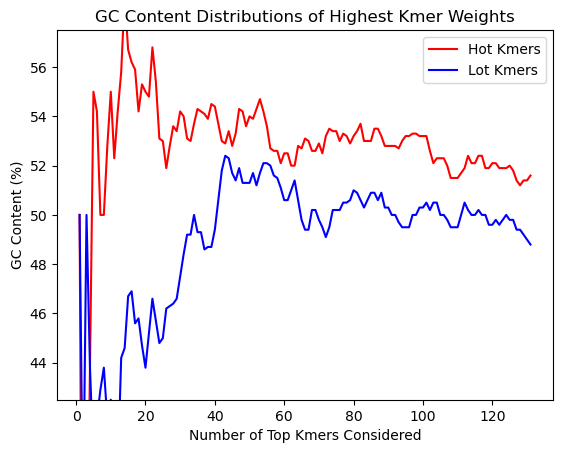

In [15]:
gc_hot = []
gc_lot = []
sorted_weights = weights.columns.values[np.argsort(-weights.values, axis=1)]
for x in range(1, 1 + math.floor(weights.shape[1] / 2)):
    gc_hot.append(gc(''.join(sorted_weights[0,:x].tolist())))
    gc_lot.append(gc(''.join(sorted_weights[0,sorted_weights.shape[1]-x:].tolist())))
x_axis = range(1, 1 + math.floor(weights.shape[1] / 2))
plt.plot(x_axis, gc_hot, 'r-', x_axis, gc_lot, 'b-')
plt.title('GC Content Distributions of Highest Kmer Weights')
plt.xlabel('Number of Top Kmers Considered')
plt.ylabel('GC Content (%)')
plt.legend(["Hot Kmers", "Lot Kmers"], loc=0)
plt.ylim(42.5, 57.5)
plt.show()

The following cell defines a helper function that performs normalization of the weights. If the weight is positive, we multiply it by the corresponding average kmer distribution across all HOT regions. Likewise if the weight is negative, we multiply it by the corresponding average kmer distribution across all LOT regions.

This way, we can find the best performing kmers in the average case and not just select kmers that have high weights but potentially low frequency. The function is applied to all the fitted weights, and the top positive and negative weights are reselected and displayed. These kmers probably better represent the actual sequential differences between HOT and LOT regions.

In [16]:
def norm(x):
    if x.item()>0:
        return kmer_dist_hot.loc[x.name] * x.item()
    return kmer_dist_lot.loc[x.name] * x.item()

weights_norm = weights.apply(norm)
weights_norm = weights_norm.to_frame().transpose()

max_weights_norm = pd.DataFrame(weights_norm.columns.values[np.argsort(-weights_norm.values, axis=1)[:,:top_kmers]])
max_weights_norm_values = weights_norm.loc[:,max_weights_norm.loc[0]]

min_weights_norm = pd.DataFrame(weights_norm.columns.values[np.argsort(weights_norm.values, axis=1)[:,:top_kmers]])
min_weights_norm_values = weights_norm.loc[:,min_weights_norm.loc[0]]

print('Top', str(top_kmers), 'positive normalized weight kmers:')
display(max_weights_norm_values)
print('Top', str(top_kmers), 'negative normalized weight kmers:')
display(min_weights_norm_values)

Top 6 positive normalized weight kmers:


,gtgt,ttat,catg,aatc,agtc,cccg
0,0.472172,0.35092,0.279183,0.259195,0.249052,0.243129


Top 6 negative normalized weight kmers:


,agag,cctt,gctc,caga,cgat,actc
0,-0.208322,-0.190787,-0.184159,-0.177816,-0.166594,-0.152461


The following cell calculates and displays the GC content of the kmers found in the previous cell.

In [17]:
hot_kmers_norm = ''.join(list(max_weights_norm_values))
lot_kmers_norm = ''.join(list(min_weights_norm_values))

print('GC content of top', str(top_kmers), 'normalized HOT kmers is: ' + str(gc(hot_kmers_norm))+'%')
print('GC content of top', str(top_kmers), 'normalized LOT kmers is: ' + str(gc(lot_kmers_norm))+'%')

GC content of top 6 normalized HOT kmers is: 45.8%
GC content of top 6 normalized LOT kmers is: 54.2%


The following cell plots the GC Content distributions when considering increasing numbers of top positive and negative  *normalized* weights.

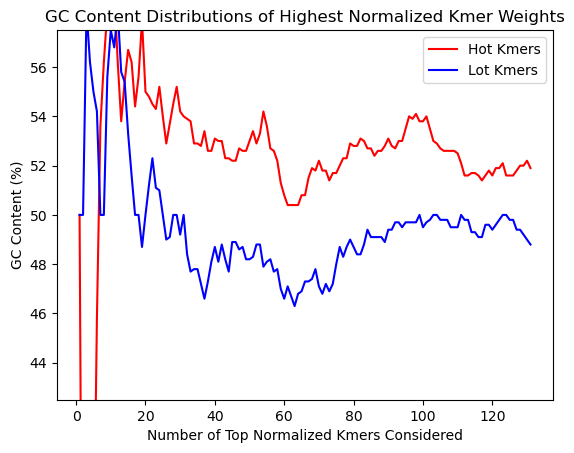

In [18]:
gc_hot = []
gc_lot = []
sorted_weights_norm = weights_norm.columns.values[np.argsort(-weights_norm.values, axis=1)]
for x in range(1, 1 + math.floor(weights_norm.shape[1] / 2)):
    gc_hot.append(gc(''.join(sorted_weights_norm[0,:x].tolist())))
    gc_lot.append(gc(''.join(sorted_weights_norm[0,sorted_weights_norm.shape[1]-x:].tolist())))
x_axis = range(1, 1 + math.floor(sorted_weights_norm.shape[1] / 2))
plt.plot(x_axis, gc_hot, 'r-', x_axis, gc_lot, 'b-')
plt.title('GC Content Distributions of Highest Normalized Kmer Weights')
plt.xlabel('Number of Top Normalized Kmers Considered')
plt.ylabel('GC Content (%)')
plt.legend(["Hot Kmers", "Lot Kmers"], loc=0)
plt.ylim(42.5, 57.5)
plt.show()

The following cell defines a helper function that calculates and returns individual nucleotide distributions for the top normalized kmer weights as a tuple. 0.01 is added to the distributions to avoid potential dividing by 0 errors. It then creates a dataframe containing nucleotide distributions for top  positive and negative normalized kmer weights.

In [19]:
def nucleotide_distributions(s):
    temp = s.lower()
    a = temp.count('a')
    g = temp.count('g')
    c = temp.count('c')
    t = temp.count('t')
    total = a + g + c + t
    a_dist = round(a/total * 100,1) + 0.01
    g_dist = round(g/total * 100,1) + 0.01
    c_dist = round(c/total * 100,1) + 0.01
    t_dist = round(t/total * 100,1) + 0.01
    return (a_dist, g_dist, c_dist, t_dist)

nucleotides = [nucleotide_distributions(hot_kmers_norm), nucleotide_distributions(lot_kmers_norm)]

nucleotides_df = pd.DataFrame(nucleotides, columns=['A Distribution', 'G Distribution', 'C Distribution', 'T Distribution'])
region = ['HOT', 'LOT']
nucleotides_df['Region'] = region
nucleotides_df.set_index('Region', drop=True, inplace=True)
nucleotides_df

,A Distribution,G Distribution,C Distribution,T Distribution
Region,,,,
HOT,20.81,20.81,25.01,33.31
LOT,25.01,20.81,33.31,20.81


The following cell performs a chi-squared test of independence to see if there is a significant difference between HOT and LOT region nucleotide distributions.

In [20]:
chi = stats.chi2_contingency(nucleotides_df)[0:3]
print('The chi-squared statistic is:', round(chi[0],5))
print('The p value is:', chi[1])

The chi-squared statistic is: 4.45333
The p value is: 0.21649121450067368
